In [2]:
require(data.table)
require(dplyr)
require(tidyverse)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

In [3]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps_discard_untrim.rds")
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 73956 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 75125 sample variables ]
tax_table()   Taxonomy Table:    [ 73956 taxa by 6 taxonomic ranks ]

In [4]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))
ps_norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 73956 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 75125 sample variables ]
tax_table()   Taxonomy Table:    [ 73956 taxa by 6 taxonomic ranks ]

In [5]:
#isolate just bacteria
ps_norm_bac=subset_taxa(ps_norm, Kingdom=="Bacteria")
ps_norm_bac
#remove chloroplast order
ps_norm_nochlo=subset_taxa(ps_norm_bac, Order!="Chloroplast")

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 71362 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 75125 sample variables ]
tax_table()   Taxonomy Table:    [ 71362 taxa by 6 taxonomic ranks ]

In [6]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_norm_nochlo) {
  sd_nochlo <- sample_data(ps_norm_nochlo)
  return(as(sd_nochlo,"data.frame"))
}

#using phyloseq nmds plot no chloroplast
sample_nochlo <- pssd2veg(ps_norm_nochlo)

In [7]:
# convert the otu_table() within a phyloseq object to a vegan compatible data object
psotu2veg <- function(ps_norm_nochlo) {
  otu_nochlo <- otu_table(ps_norm_nochlo)
  if (taxa_are_rows(otu_nochlo)) {
    otu_nochlo <- t(otu_nochlo)
  }
  return(as(otu_nochlo, "matrix"))
}

# Extract normalized OTU matrix and sample data
otu_nochlo <- psotu2veg(ps_norm_nochlo)

In [8]:
#cleaning up sample_norm to only be metadata
sample_clean <- sample_nochlo[, c("Health_Status", "colony", "Date_16S", "double_band", "date_sampled", "transect", "species", "MonthYear")]


In [9]:
# 1. create proper Date variable
sample_clean$MonthYearDate <- as.Date(
  paste0("01 ", sample_clean$MonthYear),
  format = "%d %b %Y"
)

# 2. reorder MonthYear as a factor in chronological order
sample_clean$MonthYear <- factor(
  sample_clean$MonthYear,
  levels = unique(sample_clean$MonthYear[order(sample_clean$MonthYearDate)])
)

In [10]:
# Should return TRUE
all(rownames(sample_clean) == rownames(otu_nochlo))

[1] TRUE

### dendogram

In [16]:
dij <- vegdist(otu_nochlo) ## bray curtis dissimilarity
clu <- hclust(dij, method = "average")
# 2 clusters bc I know Date_16S is already driving into 2 clusters
grp <- cutree(clu, 6)

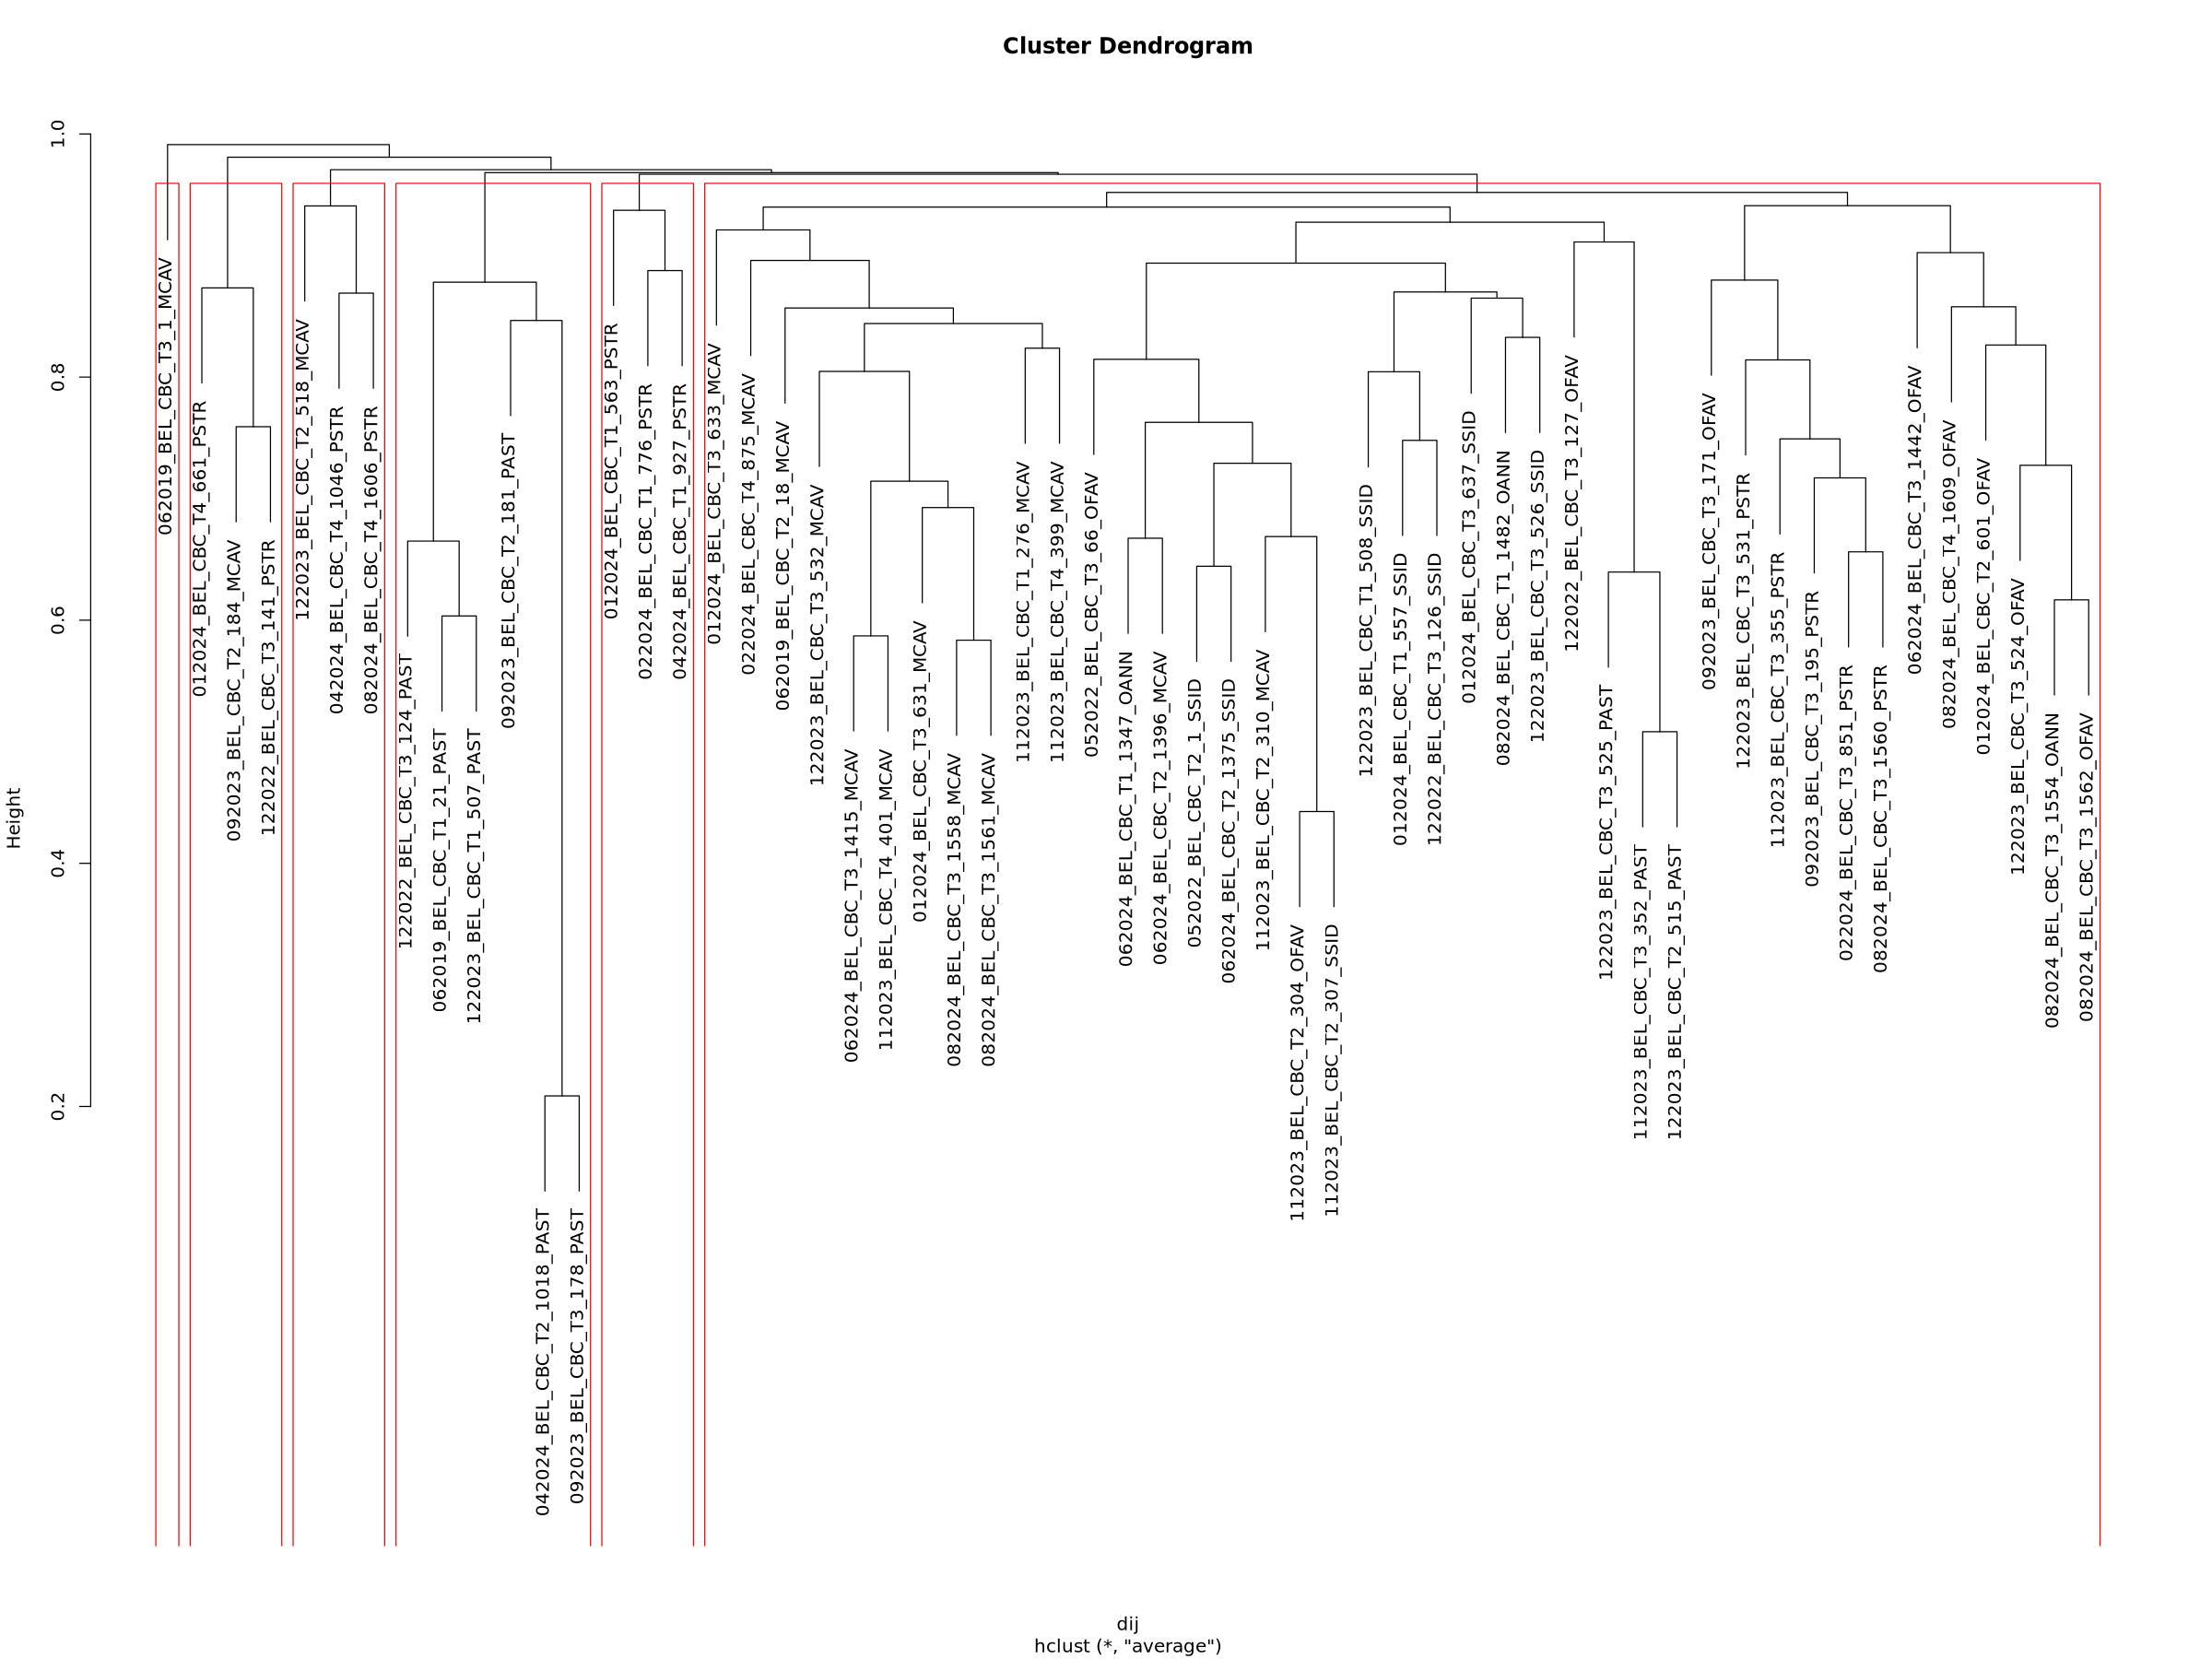

In [17]:
# visualizing the parent dendogram
plot(clu); rect.hclust(clu, k=6, border="red")

In [31]:
# If you don`t provide a dissimilarity matrix, metaMDS automatically applies Bray-Curtis. So in our case, the results would have to be the same
nmds <- metaMDS(otu_nochlo, k = 4, trymax = 100, trace = F)
class(nmds)

Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”


[1] "metaMDS" "monoMDS"

In [32]:
# basically trying to turn nmds into a dataframe
#1. Extract only the samples from nmds
nmds_points <- as.data.frame(scores(nmds, display = "sites"))
# 2. Add sample IDs 
nmds_points$SampleID <- rownames(nmds_points)

In [33]:
# Convert to data frame for safe merging
#remember grp is what I named the parent clusters when I split them for the red dendogram
clusters <- data.frame(
  SampleID = names(grp),
  cluster = factor(grp)
)
# Merge parent cluster info with NMDS points
nmds_points <- merge(nmds_points, clusters, by = "SampleID")

In [34]:
class(nmds)
class(sample_clean)
head(nmds_points)

[1] "metaMDS" "monoMDS"

[1] "data.frame"

,SampleID,NMDS1,NMDS2,NMDS3,NMDS4,cluster
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,012024_BEL_CBC_T1_557_SSID,-0.05649277,-0.090893285,-0.005216009,-0.065444415,1
2,012024_BEL_CBC_T1_563_PSTR,0.23358693,-0.164927281,-0.041462083,-0.199568993,2
3,012024_BEL_CBC_T2_601_OFAV,0.05356890,0.168178283,-0.068567912,-0.142868487,1
4,012024_BEL_CBC_T3_631_MCAV,0.23389337,0.101894828,-0.067880771,-0.115330249,1
5,012024_BEL_CBC_T3_633_MCAV,0.07224464,0.007515843,-0.206715999,-0.004186982,1
6,012024_BEL_CBC_T3_637_SSID,0.23056365,-0.121352801,-0.032906253,0.004585615,1


In [35]:
#merge nmds points with sample metadata
# easy merging by making sure sample metadata has a $SampleID column to match nmds_points 
sample_clean$SampleID <- rownames(sample_clean) 
# Merge using new SampleID column
nmds_merged <- merge(nmds_points, sample_clean, by = "SampleID")

In [36]:
any(duplicated(colnames(nmds_merged)))
colnames(nmds_merged)[duplicated(colnames(nmds_merged))]
#should be false

[1] FALSE

character(0)

In [41]:
#wider plots
#making plots small 
options(repr.plot.width = 30, repr.plot.height = 20)
#color assignment
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(20)
mycolors <- sample(mycolors, 20)

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_path()`).”


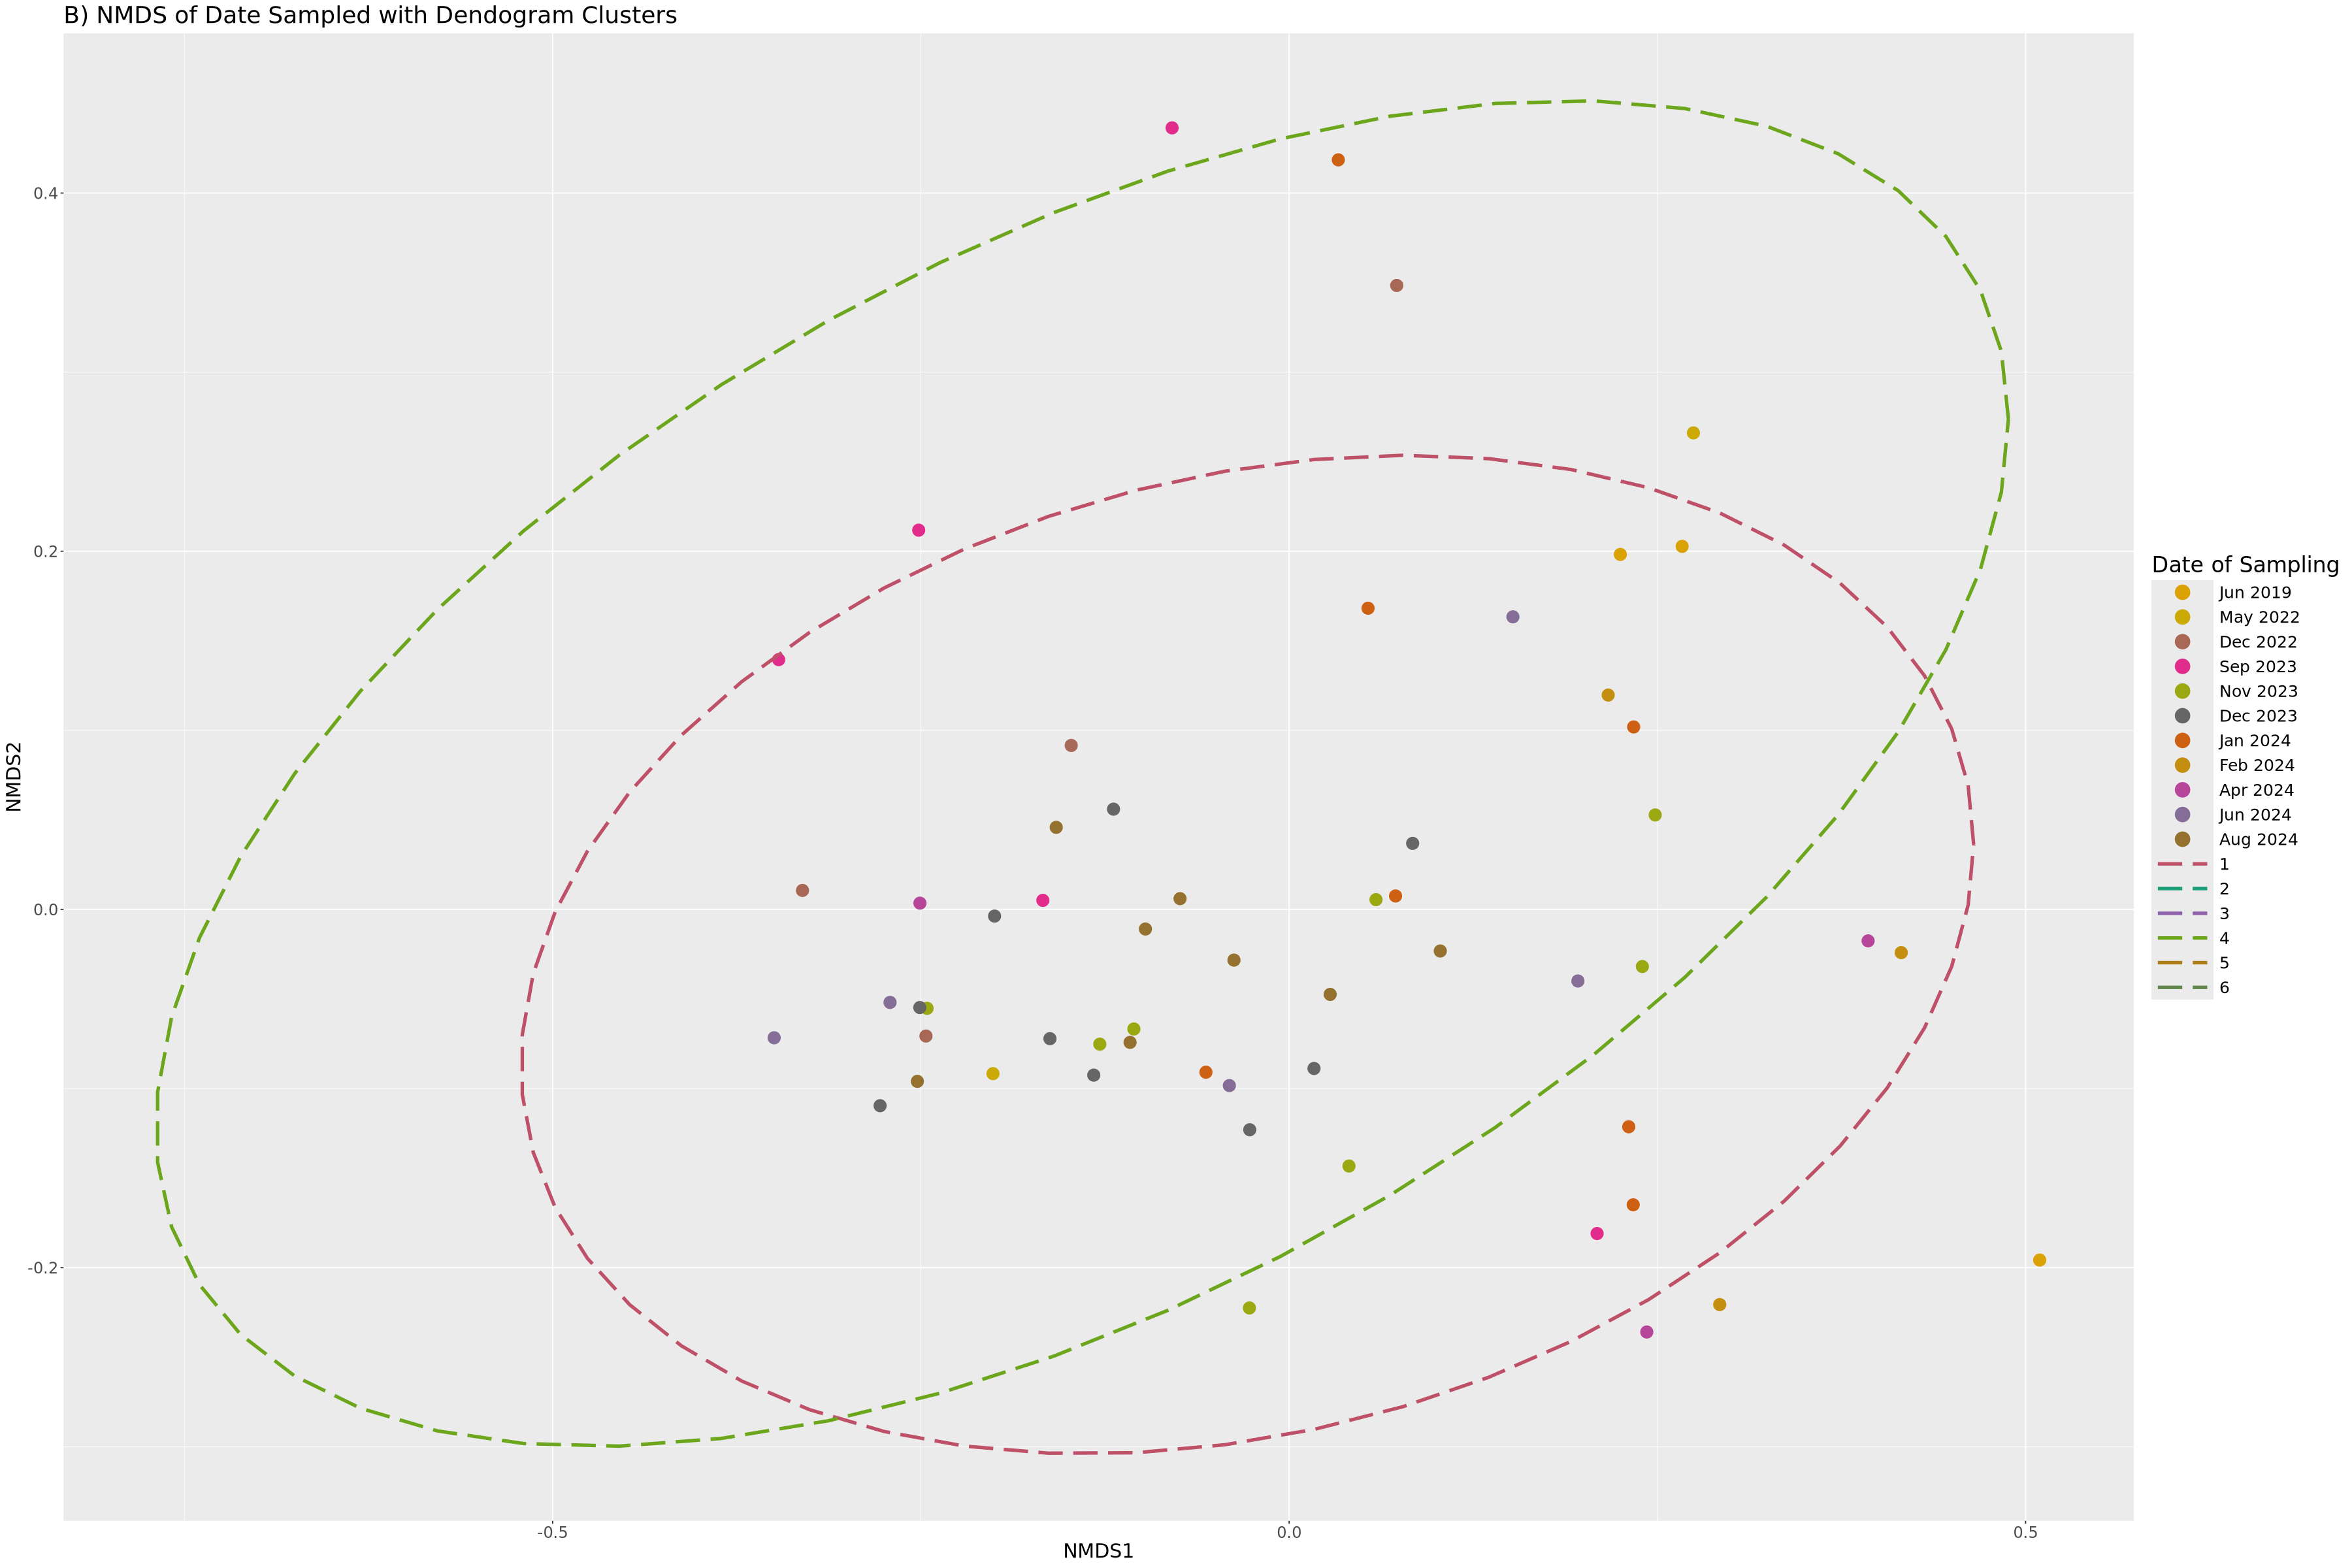

In [42]:
### no longer have to facet by parent cluster yippee

species_cluster <- ggplot(nmds_merged, aes(NMDS1, NMDS2)) +
  # Points: color by MonthYear
  geom_point(aes(color = MonthYear), size = 5, alpha = 1) +
  guides(col = guide_legend(order = 1),
          shape = guide_legend(order = 2)) +
 theme(text = element_text(size = 20)) +
  #Ellipsoids: outline by Subgroup (dashed, same color palette)
stat_ellipse(
  aes(group = cluster, color = cluster),
  type = "norm",
  level = 0.95,
  linetype = "longdash",
  linewidth = 1.5,     # thicker lines
  alpha = 1            # fully opaque
) +
  
  #Use the same color palette for both
scale_color_manual(values = mycolors, drop = TRUE) +
  
  #Axis labels and theme
  labs(x = "NMDS1", y = "NMDS2", color = "Date of Sampling", title = 'B) NMDS of Date Sampled with Dendogram Clusters')+
theme(
  legend.position = "right", 
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  text = element_text(size = 18),
  legend.key.width = unit(2, "cm"),     # make the legend keys wider
  legend.key.height = unit(0.8, "cm")   # make them taller
) +
guides(color = guide_legend(override.aes = list(size = 6))) 
species_cluster

In [44]:
# Find the convex hull of the points being plotted
hull <- nmds_merged %>%
  slice(chull(NMDS1, NMDS2))

# Define the scatterplot
p <- ggplot(nmds_merged, aes(NMDS1, NMDS2)) + geom_point(shape = 21) + 
 geom_polygon(data = hull, alpha = 0.5)

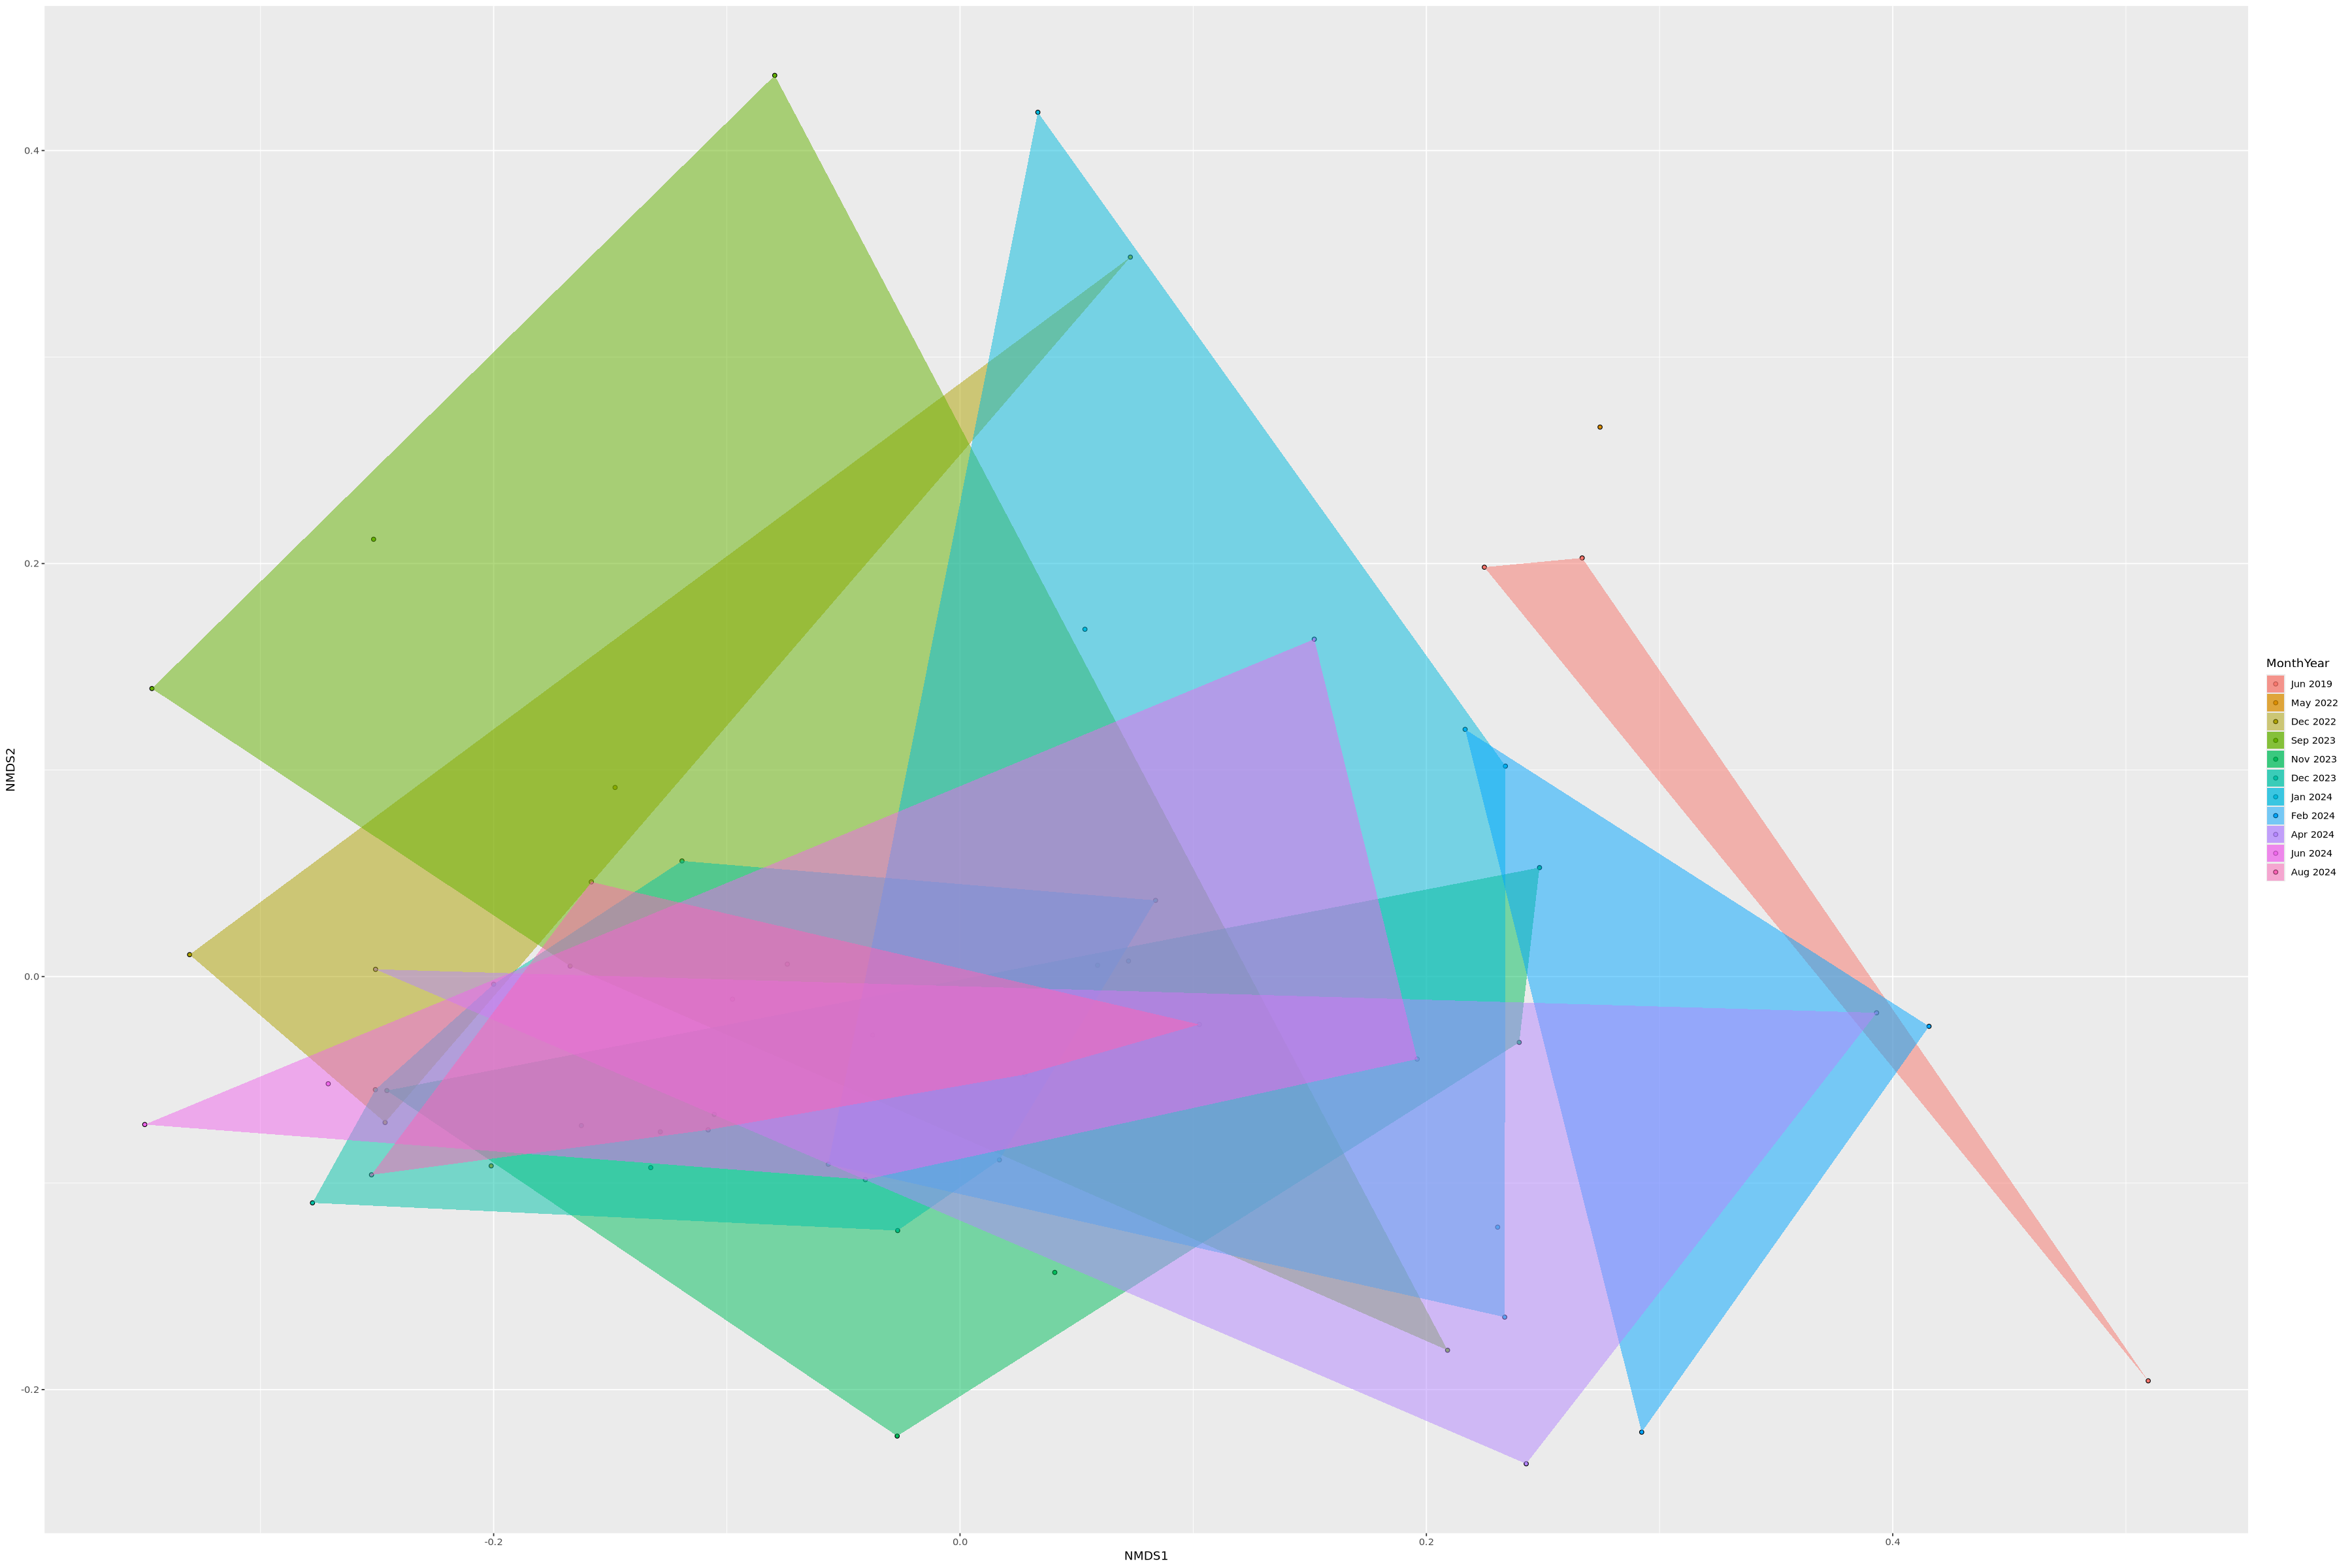

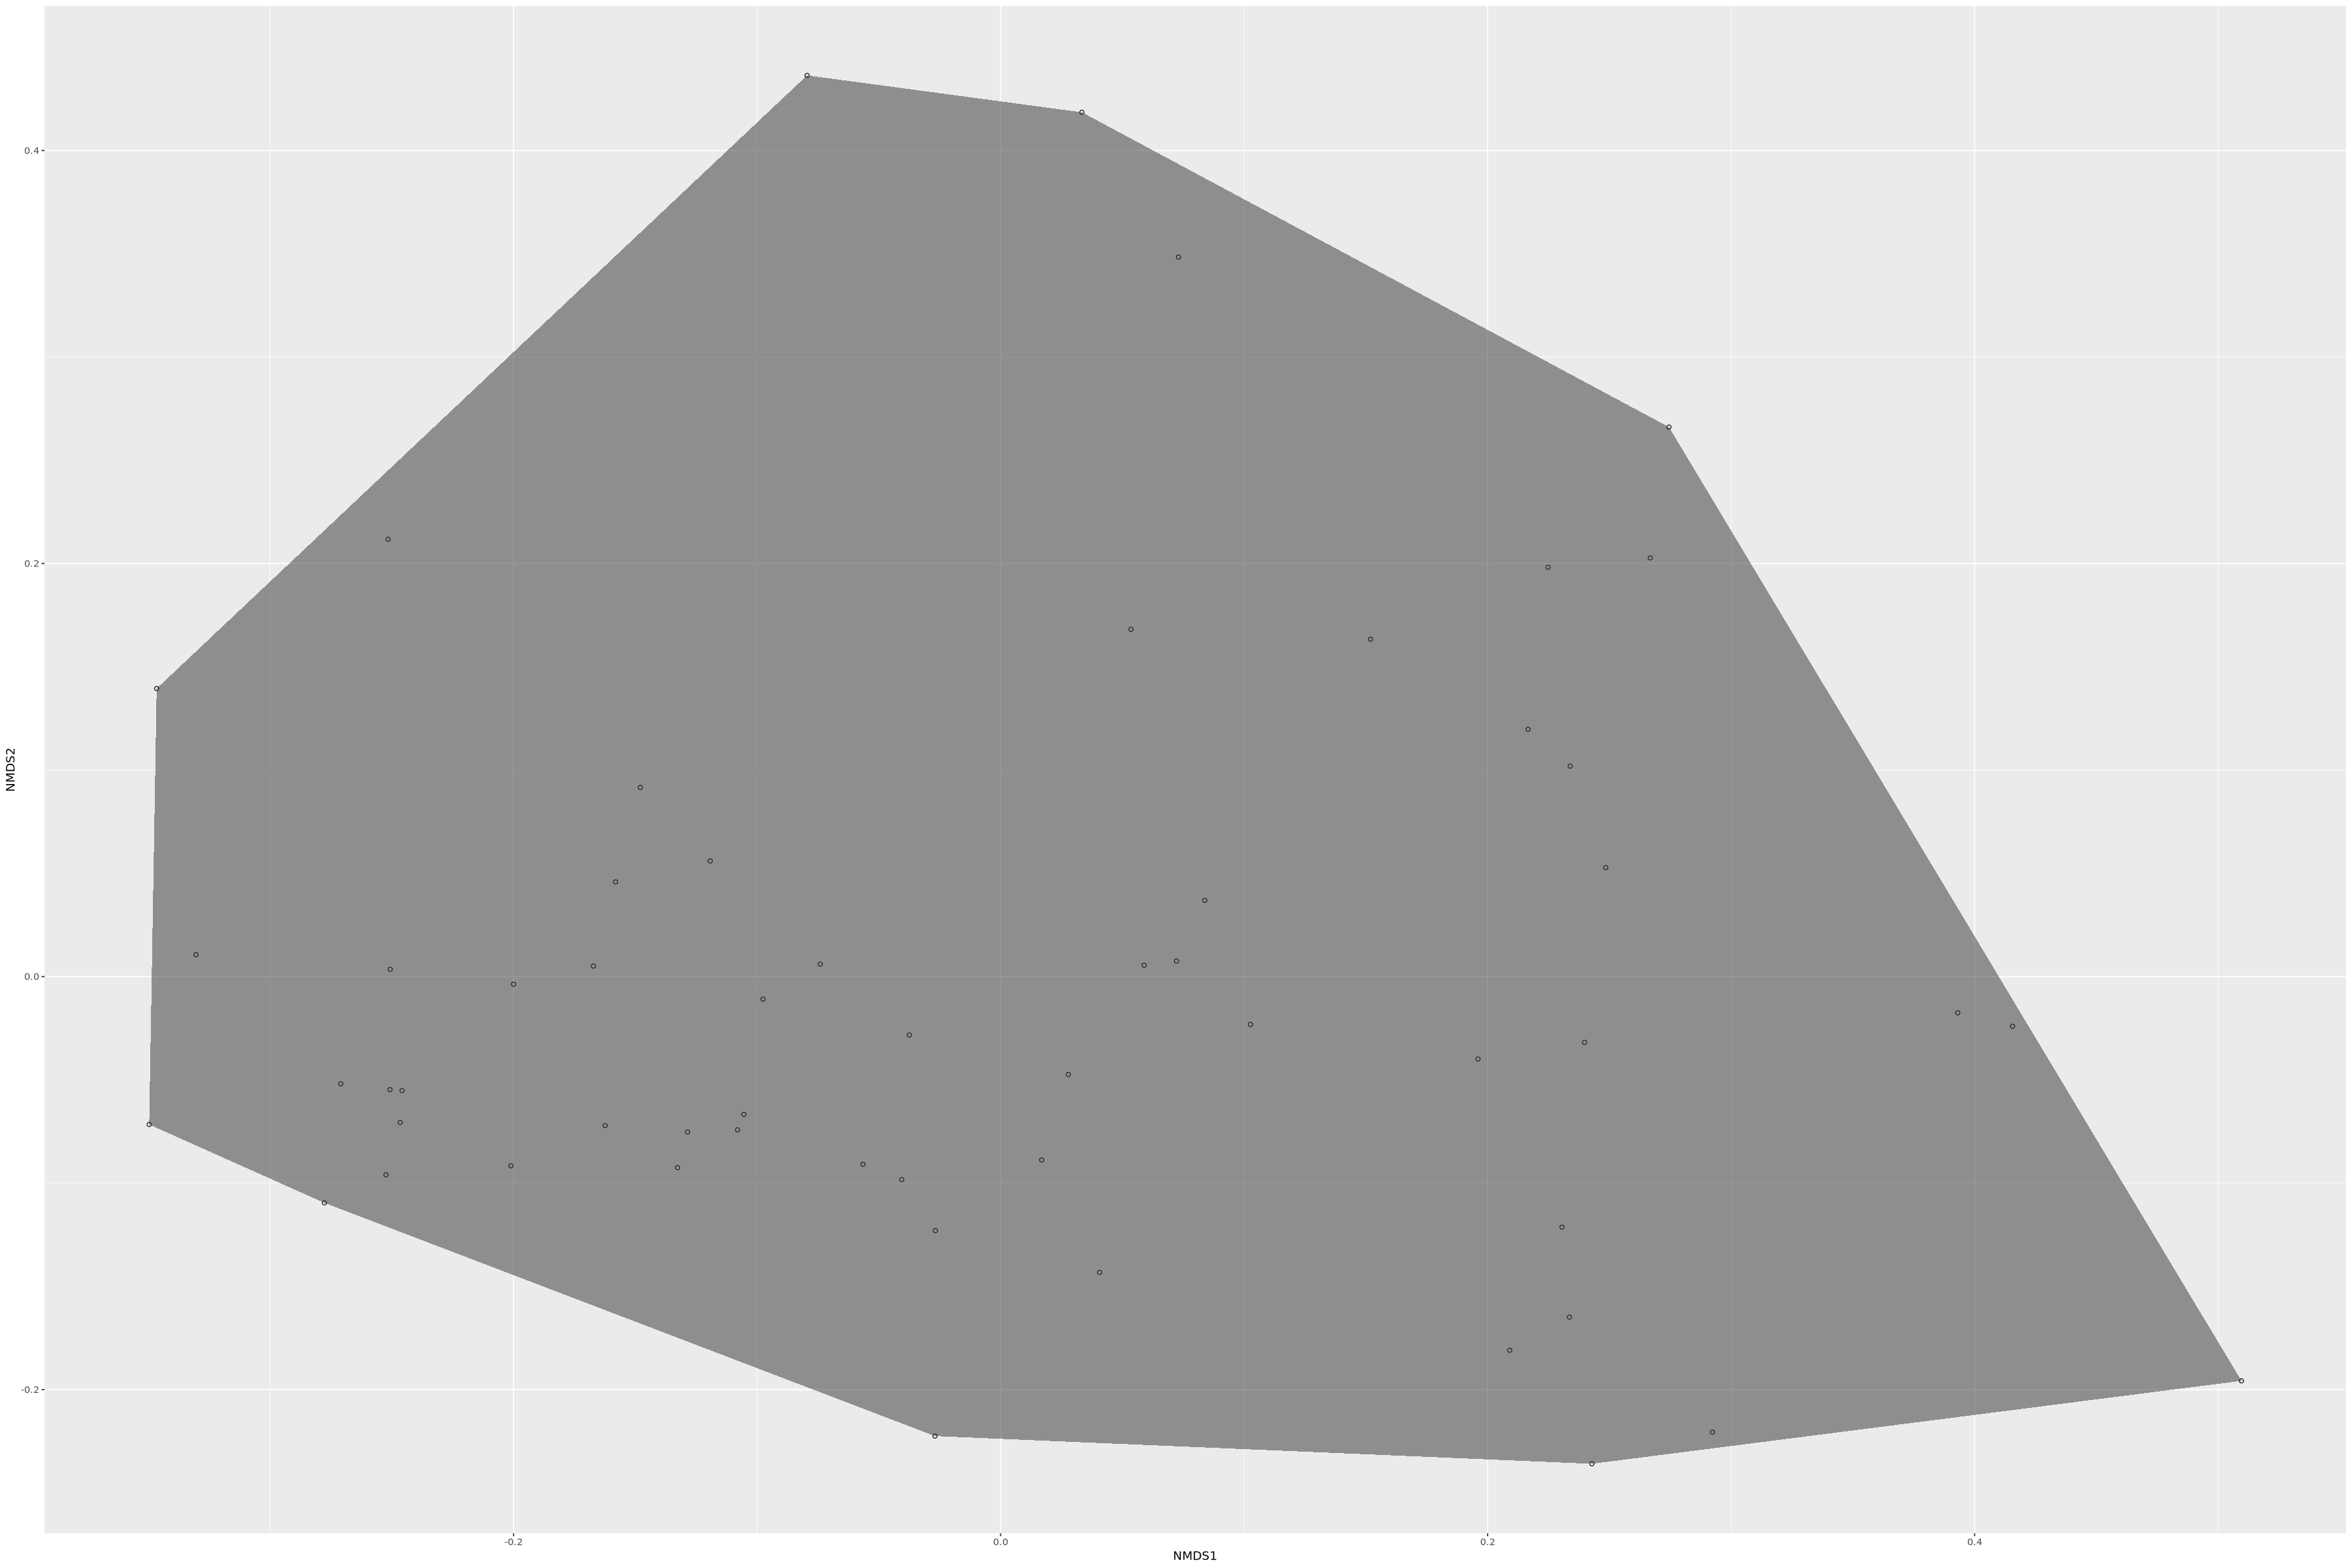

In [46]:
# Calculate the hulls for each group
hull_MonthYear <- nmds_merged %>%
  group_by(MonthYear) %>%
  slice(chull(NMDS1, NMDS2))

# Update the plot with a fill group, and overlay the new hulls
p + aes(fill = MonthYear) + geom_polygon(data = hull_MonthYear, alpha = 0.5)

p